In [187]:
import h5py
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

In [15]:
hdf5_file = "energy_data.h5"
test_hdf5_file = "angle_data.h5"

In [17]:
# Define the generator function
def hdf5_generator(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    args=[hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

# Optimize the pipeline
dataset = (dataset.prefetch(tf.data.AUTOTUNE))  # Prefetch for performance optimization

print("Train data loaded")

def test_hdf5_generator(hdf5_file):
    with h5py.File(test_hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
test_dataset = tf.data.Dataset.from_generator(
    test_hdf5_generator,
    args=[test_hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

# Optimize the pipeline
test_dataset = (test_dataset
           .prefetch(tf.data.AUTOTUNE))  # Prefetch for performance optimization

print("Validation and test data loaded")

Train data loaded
Validation and test data loaded


In [206]:
#Nazwa modelu, jakiej części datasetu chcesz używać
model_name='Klasyka'
p=0.1

In [208]:
with h5py.File(hdf5_file, "r") as hdf:
    dataset_size = len(hdf["data"])  # Or hdf["labels"], if they have the same length
    print(f"Dataset size: {dataset_size}")
train_dataset=dataset.take(int(0.8*dataset_size*p))
train_dataset=train_dataset.batch(32, drop_remainder=True)
val_dataset=test_dataset.take(int(int(0.3*dataset_size*p)))
val_dataset=val_dataset.batch(32, drop_remainder=True)
test_ds=test_dataset.skip(int(int(0.3*dataset_size*p))).take(int(int(0.1*dataset_size*p)))
test_ds=test_ds.batch(32, drop_remainder=True)
test_ds2=dataset.skip(int(0.8*dataset_size*p)).take(int(0.2*dataset_size*p))
test_ds2=test_ds2.batch(32, drop_remainder=True)
print("Dane treningowe, walidacyjne i testowe ready")

Dataset size: 450000
Dane treningowe, walidacyjne i testowe ready


In [127]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,                 # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

In [237]:
#Tu zdefiniuj model
input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')

# 3D CNN Path
x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(input_3d) 
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
# Flatten 3D features
x = layers.Flatten()(x)

# Fully Connected Layers
fc = layers.Dense(128, activation='relu')(x)
fc = layers.Dense(64, activation='relu')(fc)

# Output Layer
output = layers.Dense(1, activation='linear')(fc)

# Define the Model
model = Model(inputs=[input_3d], outputs=output)

# Compile the Model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Model Summary
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 3D_Input (InputLayer)           │ (None, 20, 110, 11, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_48 (Conv3D)              │ (None, 18, 108, 9, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_44 (MaxPooling3D) │ (None, 9, 54, 4, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_49 (Conv3D)              │ (None, 9, 54, 4, 32)   │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_45 (MaxPooling3D) │ (None, 4, 27, 2, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_50 (Conv3D)              │ (None, 4, 27, 2, 16)   │        13,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_46 (MaxPooling3D) │ (None, 2, 13, 1, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,657 (518.19 KB)

 Trainable params: 132,657 (518.19 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 3D_Input (InputLayer)           │ (None, 20, 110, 11, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_38 (Lambda)              │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_39 (Lambda)              │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [131]:
#Trening
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    shuffle=True,
    epochs=20,                 # Set a high number of epochs; EarlyStopping will stop early
    callbacks=[early_stopping],  # Add EarlyStopping to callbacks
    verbose=1
)
print("Wytrenowane!")

Epoch 1/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 568s 403ms/step - loss: 191.4656 - mean_absolute_error: 7.4060 - val_loss: 42.2548 - val_mean_absolute_error: 4.8937
Epoch 2/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 543s 386ms/step - loss: 52.4520 - mean_absolute_error: 5.4878 - val_loss: 40.1491 - val_mean_absolute_error: 4.7084
Epoch 3/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 532s 378ms/step - loss: 47.5636 - mean_absolute_error: 5.2308 - val_loss: 33.8761 - val_mean_absolute_error: 4.3734
Epoch 4/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 546s 388ms/step - loss: 45.1326 - mean_absolute_error: 5.1067 - val_loss: 32.4163 - val_mean_absolute_error: 4.2930
Epoch 5/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 548s 390ms/step - loss: 42.8907 - mean_absolute_error: 4.9909 - val_loss: 29.7449 - val_mean_absolute_error: 4.1287
Epoch 6/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 553s 393ms/step - loss: 41.3533 - mean_absolute_error: 4.9040 - val_loss: 29.5564 - val_mean_absolute_error: 4.0799
Epoch 7/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 557s 396m

In [218]:
test_loss_ang, test_mae_ang = model.evaluate(test_ds)
print("Kątowe MAE dla sieci:", test_mae_ang)
test_loss_base, test_mae_base = model.evaluate(test_ds2)
print("Bazowe MAE dla sieci:", test_mae_base)

1406/1406 ━━━━━━━━━━━━━━━━━━━━ 138s 29ms/step - loss: 284.4442 - mae: 14.0393
Kątowe MAE dla sieci: 13.980521202087402
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 311s 25ms/step - loss: 440.7021 - mae: 17.9244
Bazowe MAE dla sieci: 17.91946029663086


In [231]:
y_pred=model.predict(test_ds).flatten()
y_true = np.array([label.numpy() for _, label in test_ds]).flatten()
y_pred2=model.predict(test_ds2).flatten()
y_true2 = np.array([label.numpy() for _, label in test_ds2]).flatten()
y_true=np.concatenate((y_true,y_true2),axis=0)
y_pred=np.concatenate((y_pred,y_pred2),axis=0)

1406/1406 ━━━━━━━━━━━━━━━━━━━━ 155s 25ms/step
2812/2812 ━━━━━━━━━━━━━━━━━━━━ 345s 27ms/step


C:\Users\spbki\AppData\Local\Temp\ipykernel_7628\3879116691.py:10: RuntimeWarning: Mean of empty slice.
  mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]


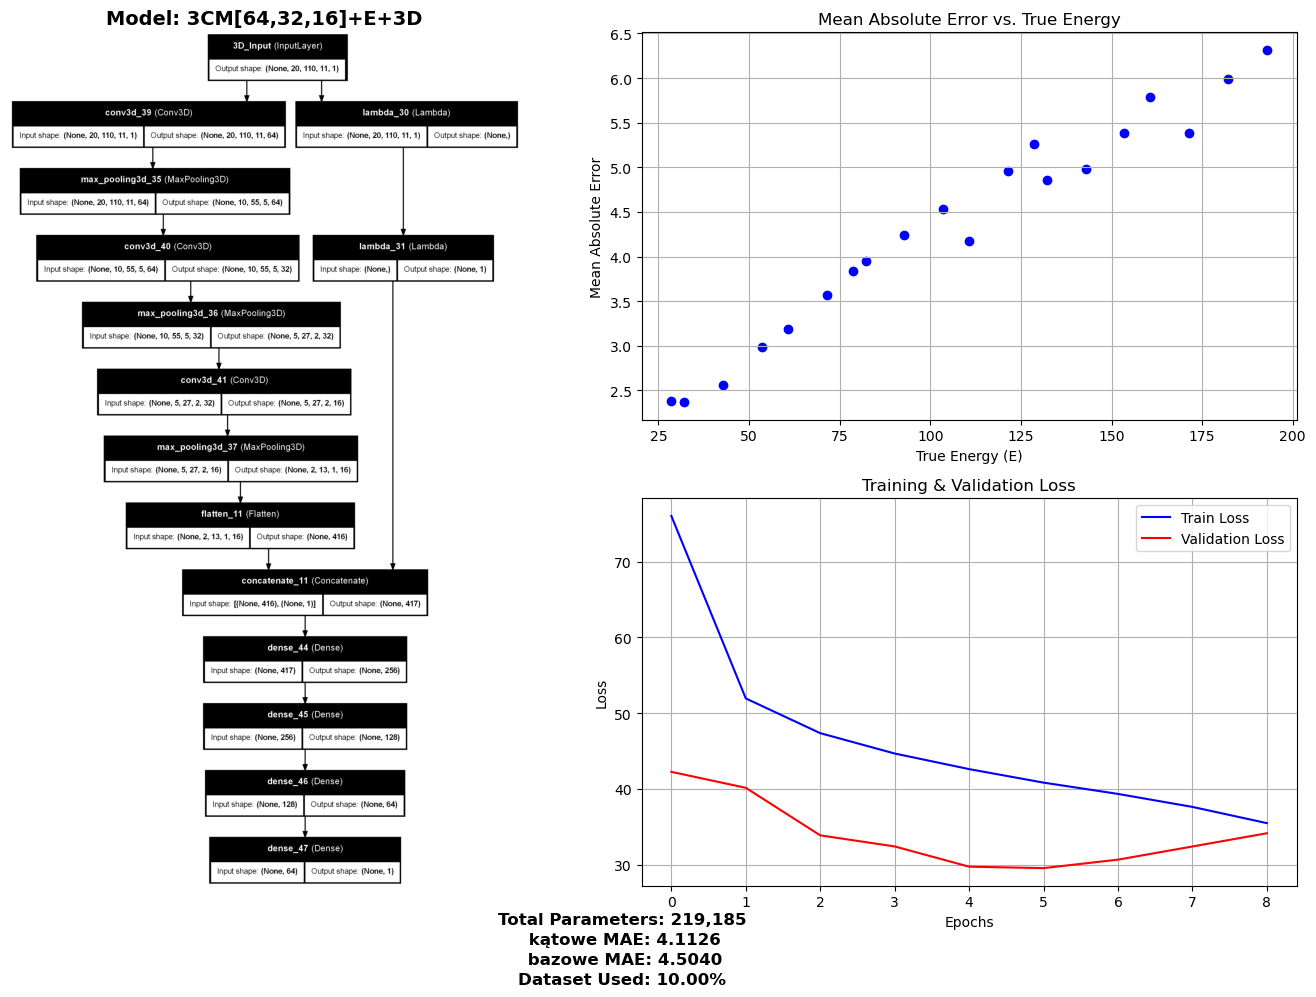

In [195]:
# --- Step 1: Load Model Diagram ---
model_img = mpimg.imread('model.png')
infographic_filename = f"{model_name}_infographic.png"

# --- Step 2: Compute Mean Absolute Error vs. True Energy ---
error = np.abs(y_true - y_pred)
num_bins = 50
bins = np.linspace(y_true.min(), y_true.max(), num_bins)
bin_indices = np.digitize(y_true, bins)
mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]

# Total Parameters
total_params = model.count_params()

# --- Step 4: Create Infographic Layout ---
fig = plt.figure(figsize=(14, 10))

# Create a 2x2 grid (but make the first column span two rows)
grid_spec = fig.add_gridspec(2, 2, width_ratios=[1, 1])  # 1st column will span both rows

# --- Column 1 (Left) - Model Diagram (Spanning both rows) ---
ax1 = fig.add_subplot(grid_spec[:, 0])
ax1.imshow(model_img)
ax1.axis('off')  # Hide axes
ax1.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold')

# --- Column 2, Row 1 - MAE vs True Energy ---
ax2 = fig.add_subplot(grid_spec[0, 1])
ax2.scatter(bins[1:], mean_error, marker='o', color='blue')
ax2.set_xlabel("True Energy (E)")
ax2.set_ylabel("Mean Absolute Error")
ax2.set_title("Mean Absolute Error vs. True Energy", fontsize=12)
ax2.grid(True)

# --- Column 2, Row 2 - Training & Validation Loss ---
ax3 = fig.add_subplot(grid_spec[1, 1])
ax3.plot(history.history['loss'], label='Train Loss', color='blue')
ax3.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")
ax3.set_title("Training & Validation Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

# --- Step 5: Add Captions ---
# Captions for MAE, Dataset percentage, Total Parameters
fig.text(0.5, 0.05, f" kątowe MAE: {test_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0.03, f" bazowe MAE: {test_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.5, 0.01, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Add Model Summary and Total Parameters ---
fig.text(0.5, 0.07, f"Total Parameters: {total_params:,}", ha='center', fontsize=12, fontweight='bold')

# --- Save or Show Infographic ---
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit captions
plt.savefig(infographic_filename, dpi=300)
plt.show()
